# 펭귄 몸무게 예측 dacon

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# 다운받은 csv를 pandas의 DataFrame 형식으로 불러옵니다.
import pandas as pd 
df_train = pd.read_csv('./dataset/train.csv')
df_test = pd.read_csv('./dataset/test.csv')



features 파악

In [2]:
df_train.info(), df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   114 non-null    int64  
 1   Species              114 non-null    object 
 2   Island               114 non-null    object 
 3   Clutch Completion    114 non-null    object 
 4   Culmen Length (mm)   114 non-null    float64
 5   Culmen Depth (mm)    114 non-null    float64
 6   Flipper Length (mm)  114 non-null    int64  
 7   Sex                  111 non-null    object 
 8   Delta 15 N (o/oo)    111 non-null    float64
 9   Delta 13 C (o/oo)    111 non-null    float64
 10  Body Mass (g)        114 non-null    int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 9.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --

(None, None)

In [3]:
df_train.drop('id', axis=1, inplace = True) # id는 제외하고 분석
df_test.drop('id', axis=1, inplace = True)
print(f'df_train 결측치 조회\n{df_train.isna().sum()}') 
print(f'df_test 결측치 조회\n{df_test.isna().sum()}')


df_train 결측치 조회
Species                0
Island                 0
Clutch Completion      0
Culmen Length (mm)     0
Culmen Depth (mm)      0
Flipper Length (mm)    0
Sex                    3
Delta 15 N (o/oo)      3
Delta 13 C (o/oo)      3
Body Mass (g)          0
dtype: int64
df_test 결측치 조회
Species                0
Island                 0
Clutch Completion      0
Culmen Length (mm)     0
Culmen Depth (mm)      0
Flipper Length (mm)    0
Sex                    6
Delta 15 N (o/oo)      9
Delta 13 C (o/oo)      8
dtype: int64


결측치가 train셋에는 9개, test셋에는 23개가 있습니다. 적절히 처리해주어야 할 것 같습니다!

In [4]:
df_train.fillna(df_train.mean(), inplace=True)
df_test.fillna(df_train.mean(), inplace=True)

df_train.isna().sum(), df_test.isna().sum()

temp_train = df_train.dropna()
temp_test = df_test.dropna()

숫자형 데이터에 대해서는 평균값을 적용해 주었고 성별에 따른 몸무게의 변화가 클 것으로 예상해서 성별은 보간법을 사용하였습니다!

# Sex에 대하여 보간법 진행
보간법은 쉽게말해 'Sex'를 예측하는 모델을 만들고 그 예측 값을 넣어주는 것을 의미합니다.



In [5]:
X_train_Sex = temp_train.select_dtypes(include=['int', 'float'])
X_train_Sex = X_train_Sex.drop('Body Mass (g)', axis=1)
Y_train_Sex = temp_train['Sex']

from sklearn.model_selection import train_test_split

sex_x_train, sex_x_test, sex_y_train, sex_y_test = train_test_split(X_train_Sex, Y_train_Sex)
from sklearn.ensemble import RandomForestClassifier
model_sex = RandomForestClassifier().fit(sex_x_train, sex_y_train)
model_sex.score(sex_x_test, sex_y_test)

0.8214285714285714

RandomForestClassifier 모델을 통해 성별을 예측하는 모델을 만들었습니다.

In [6]:
df_train.isna().sum()

Species                0
Island                 0
Clutch Completion      0
Culmen Length (mm)     0
Culmen Depth (mm)      0
Flipper Length (mm)    0
Sex                    3
Delta 15 N (o/oo)      0
Delta 13 C (o/oo)      0
Body Mass (g)          0
dtype: int64

train셋 결측치 대체

In [7]:
df_train.loc[df_train['Sex'].isna(), 'Sex'] = model_sex.predict(df_train[df_train['Sex'].isna()].select_dtypes(include=['int', 'float']).drop('Body Mass (g)', axis=1))

train셋 결측치 대체

In [8]:
df_test.loc[df_test['Sex'].isna(), 'Sex'] = model_sex.predict(df_test[df_test['Sex'].isna()].select_dtypes(include=['int', 'float']))

한 줄로 동시에 쓰느랴 복잡해 보이지만, 'Sex'에 대해 학습된 model_sex의 predict를 사용하여 값을 가져와 대입시켜주었습니다. 여기서 select_dtypes는 지정된 열의 타입만 가져오게 됩니다. 저는 int형과 float형을 추출하였고, test셋에는 'Body Mass (g)' 컬럼이 없기 때문에, 이를 포함하여 학습을 시키면 안됩니다. 따라서 drop을 통해 해당 열을 제거하였습니다.

성별 숫자화 (MALE: 0, FEMALE: 1)

In [9]:
temp_train.loc[df_train['Sex'] == 'MALE', 'Sex'] = 0
temp_train.loc[df_train['Sex'] == 'FEMALE', 'Sex'] = 1

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [10]:
df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)

pd.get_dummies함수는 정형 데이터에 대해 자동으로 One-Hot인코딩을 진행해주는 똑똑한 함수입니다.

In [11]:
X = df_train.drop('Body Mass (g)', axis=1) # label을 제외한 나머지 컬럼들을 X에 저장합니다.
Y = df_train['Body Mass (g)'] # label인 Body mess를 Y에 저장합니다.
Y

0      5550
1      3800
2      4400
3      4850
4      5700
       ... 
109    3700
110    4250
111    4100
112    2700
113    5600
Name: Body Mass (g), Length: 114, dtype: int64

/home/work/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/work/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/work/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/work/.local/lib/

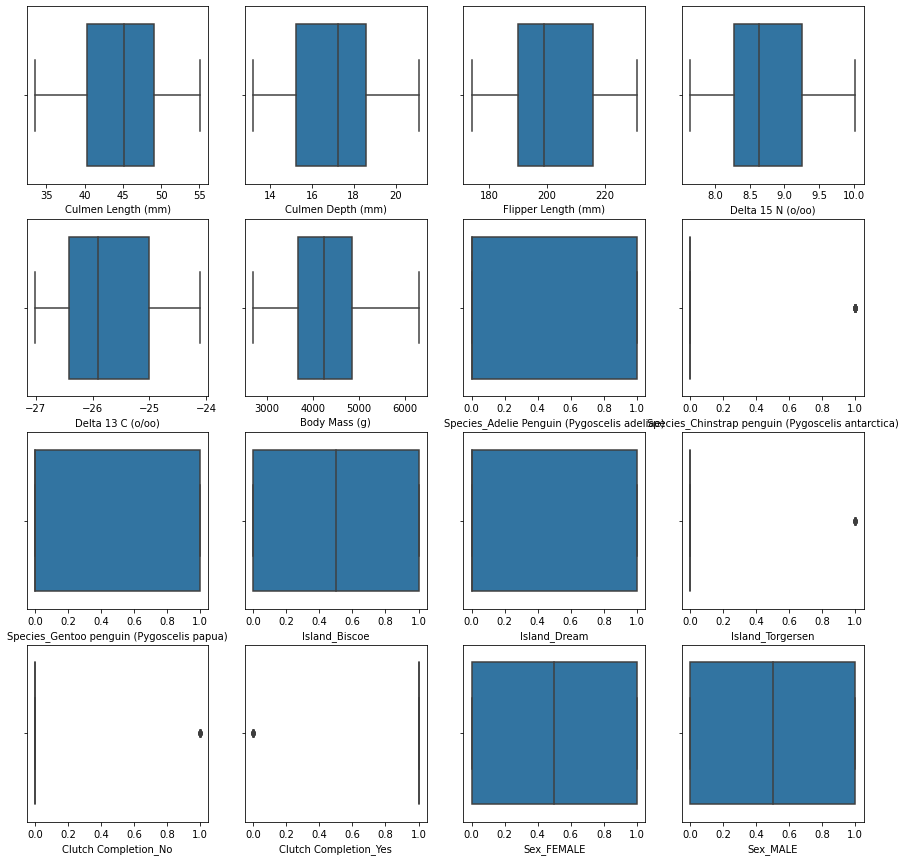

In [12]:
plt.figure(figsize=(15, 15))

for idx, col in enumerate(list(df_train)):
    plt.subplot(4, 4, idx+1)
    sns.boxplot(df_train[col])

In [13]:
X

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Delta 15 N (o/oo),Delta 13 C (o/oo),Species_Adelie Penguin (Pygoscelis adeliae),Species_Chinstrap penguin (Pygoscelis antarctica),Species_Gentoo penguin (Pygoscelis papua),Island_Biscoe,Island_Dream,Island_Torgersen,Clutch Completion_No,Clutch Completion_Yes,Sex_FEMALE,Sex_MALE
0,50.0,15.3,220,8.305150,-25.190170,0,0,1,1,0,0,0,1,0,1
1,49.5,19.0,200,9.630740,-24.346840,0,1,0,0,1,0,1,0,0,1
2,45.1,14.4,210,8.519510,-27.018540,0,0,1,1,0,0,0,1,1,0
3,44.5,14.7,214,8.201060,-26.165240,0,0,1,1,0,0,0,1,1,0
4,49.6,16.0,225,8.383240,-26.842720,0,0,1,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,36.6,17.8,185,8.737634,-25.723051,1,0,0,0,0,1,0,1,1,0
110,39.2,18.6,190,9.110060,-25.795490,1,0,0,0,1,0,0,1,0,1
111,43.2,18.5,192,8.970250,-26.036790,1,0,0,0,1,0,0,1,0,1
112,46.9,16.6,192,9.805890,-24.737350,0,1,0,0,1,0,1,0,1,0


In [14]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)

In [15]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

모델의 선택은 시행착오라고 배웠습니다. 따라서 여러 개의 모델들의 성능을 출력해보고 그 중 탑3를 가져와 앙상블을 진행해보겠습니다.

In [16]:
score_List=[]

In [17]:
model = KNeighborsRegressor(n_neighbors=5).fit(x_train, y_train)
score_List.append(f'KNeighborsRegressor: train_score: {model.score(x_train, y_train)}, val_score: {model.score(x_test, y_test)}')

model = LinearRegression().fit(x_train, y_train)
score_List.append(f'LinearRegression: train_score: {model.score(x_train, y_train)}, val_score: {model.score(x_test, y_test)}')

model = Ridge().fit(x_train, y_train)
score_List.append(f'Ridge: train_score: {model.score(x_train, y_train)}, val_score: {model.score(x_test, y_test)}')

model = Lasso().fit(x_train, y_train)
score_List.append(f'Lasso: train_score: {model.score(x_train, y_train)}, val_score: {model.score(x_test, y_test)}')

model = DecisionTreeRegressor().fit(x_train, y_train)
score_List.append(f'DecisionTreeRegressor: train_score: {model.score(x_train, y_train)}, val_score: {model.score(x_test, y_test)}')

model = RandomForestRegressor().fit(x_train, y_train)
score_List.append(f'RandomForestRegressor: train_score: {model.score(x_train, y_train)}, val_score: {model.score(x_test, y_test)}')

model = GradientBoostingRegressor().fit(x_train, y_train)
score_List.append(f'GradientBoostingRegressor: train_score: {model.score(x_train, y_train)}, val_score: {model.score(x_test, y_test)}')

model = XGBRegressor().fit(x_train, y_train)
score_List.append(f'XGBRegressor: train_score: {model.score(x_train, y_train)}, val_score: {model.score(x_test, y_test)}')

model = LGBMRegressor().fit(x_train, y_train)
score_List.append(f'LGBMRegressor: train_score: {model.score(x_train, y_train)}, val_score: {model.score(x_test, y_test)}')

In [18]:
[print(i) for i in score_List]

KNeighborsRegressor: train_score: 0.8480426204712608, val_score: 0.6942956363515327
LinearRegression: train_score: 0.8748397552288102, val_score: 0.7657539048128132
Ridge: train_score: 0.8732915508527898, val_score: 0.7676730940802267
Lasso: train_score: 0.8746913311471938, val_score: 0.7717934644698524
DecisionTreeRegressor: train_score: 1.0, val_score: 0.5362749775327023
RandomForestRegressor: train_score: 0.9761125893067262, val_score: 0.692605523071973
GradientBoostingRegressor: train_score: 0.9925865742732187, val_score: 0.6284569005210976
XGBRegressor: train_score: 0.9999999968754548, val_score: 0.3510538661674739
LGBMRegressor: train_score: 0.9205606647287853, val_score: 0.7013785158499707


[None, None, None, None, None, None, None, None, None]

train_score가 아닌 val_score를 봐주셔야합니다.

LinearRegression, Ridge, Lasso, LGBMRegressor 등이 성능이 좋게 나온 것을 확인할 수 있었습니다.

In [19]:
model_LR = LinearRegression().fit(X, Y)
model_RID = Ridge().fit(X, Y)
model_LA = Lasso().fit(X, Y)
model_LGBM = LGBMRegressor().fit(X, Y)
model_XGB = XGBRegressor().fit(X, Y)

random_state가 없기 때문에 순위는 항상 바뀝니다.
저는 LinearRegression, Ridge, Lasso, XGBRegressor, LGBMRegressor 모델을 택했습니다.

In [20]:
df_test

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Delta 15 N (o/oo),Delta 13 C (o/oo),Species_Adelie Penguin (Pygoscelis adeliae),Species_Chinstrap penguin (Pygoscelis antarctica),Species_Gentoo penguin (Pygoscelis papua),Island_Biscoe,Island_Dream,Island_Torgersen,Clutch Completion_No,Clutch Completion_Yes,Sex_FEMALE,Sex_MALE
0,52.0,20.7,210.0,9.43146,-24.68440,0,1,0,0,1,0,0,1,0,1
1,55.9,17.0,228.0,8.31180,-26.35425,0,0,1,1,0,0,0,1,0,1
2,38.9,18.8,190.0,8.36936,-26.11199,1,0,0,0,1,0,0,1,1,0
3,45.2,16.6,191.0,9.62357,-24.78984,0,1,0,0,1,0,0,1,1,0
4,37.9,18.6,172.0,8.38404,-25.19837,1,0,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,49.3,19.9,203.0,9.88809,-24.59513,0,1,0,0,1,0,0,1,0,1
224,46.5,14.8,217.0,8.58487,-26.59290,0,0,1,1,0,0,0,1,1,0
225,46.5,13.5,210.0,7.99530,-25.32829,0,0,1,1,0,0,0,1,1,0
226,50.5,19.6,201.0,9.80590,-24.72940,0,1,0,0,1,0,0,1,0,1


앙상블 진행, 사실 저도 머신러닝 초보이기때문에 이 개념이 앙상블이 맞는지는 모르겠습니다. 하지만 단언컨데 성능향상은 확실했습니다.

In [21]:
pred_LR = model_LR.predict(df_test)
pred_RID = model_RID.predict(df_test)
pred_LA = model_LA.predict(df_test)
pred_LGBM = model_LGBM.predict(df_test)
pred_XGB = model_XGB.predict(df_test)
pred = pred_LR*0.2 + pred_RID*0.2 + pred_LA*0.2 + pred_LGBM*0.2 + pred_XGB*0.2
pred

array([4269.61321339, 5620.65906474, 3547.8072989 , 3377.79493883,
       3498.12207803, 4160.72271767, 4581.0695603 , 5187.29344116,
       4722.5970101 , 4124.82370156, 4184.79835192, 4569.17359212,
       4730.8361955 , 4746.2736748 , 5141.70464143, 5256.48969631,
       4103.1051987 , 3981.41985011, 3483.44866052, 3573.42660401,
       4175.80985887, 5568.67151906, 5457.76936193, 4054.52601156,
       3434.79942153, 4614.35565937, 3439.34051059, 4003.09678973,
       4095.80646671, 4742.59079707, 3579.96101166, 4732.28361918,
       3600.39138445, 4997.33720851, 3946.07970401, 3295.68485221,
       4610.81851284, 3683.90574338, 4078.05458798, 4666.42000383,
       4073.38024371, 3600.89999278, 4028.95195222, 5385.31907293,
       3730.66947949, 4680.85073596, 3464.41815432, 4276.37493306,
       4796.10429505, 5559.92008789, 3689.25054191, 4199.91779142,
       3419.6315792 , 4190.69209961, 4223.68623856, 4090.9664929 ,
       4717.44664789, 4129.55119667, 4685.86575967, 3659.07671

In [22]:
submission = pd.read_csv('./dataset/submission.csv')
submission['Body Mass (g)'] = pred

submission.to_csv('./submission.csv', index=False)
submission

,id,Body Mass (g)
0,0,4269.613213
1,1,5620.659065
2,2,3547.807299
3,3,3377.794939
4,4,3498.122078
...,...,...
223,223,4095.895891
224,224,4693.447304
225,225,4626.138584
226,226,3961.490889
